# Analyzing Agilent chromatograms exported to .cdf format

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak                        # library for dealing with jagged arrays
from tslearn.metrics import dtw, dtw_path   # dyanmic time warping functions
from sklearn_extra.cluster import KMedoids
import json
import copy
import os
import warnings

# read in anonymized filepath
with open('chrom_path.txt', 'r') as file:
    base_path = file.read()
    instrument_path = os.path.join(base_path, 'Channel 107', 'CDF')

# pull all of the .cdf files
chrom_files = []
for file in os.listdir(instrument_path):
    if file.endswith('.cdf'):
        chrom_files.append(file)

chrom_file = chrom_files[0]  # grab one from the list
filepath = os.path.join(instrument_path, chrom_file)

C:\Users\Jordan.Welch\AppData\Roaming\Python\Python311\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


### Check the file's variables

In [2]:
ds = Dataset(filepath, 'r')
for key in ds.variables.keys():
    print(key)

actual_sampling_interval
actual_delay_time
actual_run_time_length
detector_maximum_value
detector_minimum_value
peak_retention_time
peak_name
peak_amount
peak_start_time
peak_end_time
peak_width
peak_area
peak_area_percent
peak_height
peak_height_percent
baseline_start_time
baseline_start_value
baseline_stop_time
baseline_stop_value
peak_start_detection_code
peak_stop_detection_code
retention_index
peak_asymmetry
peak_efficiency
ordinate_values


### Define objects that can structure peak data for us

In [3]:
class Peak:
    """
    Encapsulates individual peak data

    Attributes:
        name (str):              Name of the analyte to which the peak belongs.
        start_time (numeric):    Retention time at which peak integration begins.
        stop_time (numeric):     Retention time at which peak integration ends.
        apex_time (numeric):     Retention time of the peak apex.
        rrt_apex (numeric):     Retention time of apex scaled to the retention time of an anchor peak.
        height (numeric):        Signal intensity at the apex, or max height of the peak.
    """

    def __init__(self, name, start, stop, area, signal, time):
        """
        Initializes the Peak object.

        Params:
            name (str):           Name of the analyte to which the peak belongs.
            start (numeric):      Retention time at which peak integration begins.
            stop (numeric):       Retention time at which peak integration ends.
            signal (np.ndarray):  Array of detector signal intensities--the chromatogram itself.
            time (np.ndarray):    The time axis of the chromatogram in minutes.
        """
        
        self.name = name
        self.start_time = start  
        self.stop_time = stop    
        self.area = area         
        self.apex_time, self.height = self._get_apex(signal, time)
        self.rrt_apex = self.apex_time    

    def _get_apex(self, signal, time):
        """
        Get the retention time and height of the peak apex

        Params:
            signal (np.ndarray):  Array of signal intensities--the chromatogram itself.
            time (np.ndarray):    The time axis of the chromatogram in minutes.
        """

        # find indices in the time array that match the start and stop times.
        # it is necessary to do it this way because elements in the time array may not perfectly line up with any given start/stop time due to 
        # floating point imprecision.  as such, we need to find indices to elements in the time array that most closely approximate 
        # the start/stop times given in the original data file.  
        start_idx = (np.abs(time - self.start_time)).argmin()
        stop_idx = (np.abs(time - self.stop_time)).argmin()
    
        # extract the peak from the raw chromatogram
        peak_sig = signal[start_idx : stop_idx] 
    
        # get the index of the apex
        ret_time_idx = peak_sig.argmax() + start_idx  # offset to where the array slice was taken

        # get the peak height at its apex
        height = signal[ret_time_idx]

        # get the retention time in minutes corresponding to the peak apex
        ret_time = time[ret_time_idx]
    
        return ret_time, height

    def scale_retention_time(self, ref_peak):
        """
        Scale the retention time relative to that of a reference peak.  The outcome will be a dimensionless quantity representing
        how far away this peak is from the reference peak.  The idea is to be able to compare chromatograms across instruments and across time,
        where the absolute retention times of various peaks will vary by some amount.

        This function both sets and returns the value of the norm_apex attribute.

        params:
            ref_peak (Peak):  User-defined reference peak.
        """
        
        self.rrt_apex = self.apex_time / ref_peak.apex_time

        return self.rrt_apex

### Establish peak groups

##### We will do this by iterating over the named peaks and record the retention time at which an uninterrupted series of peaks begins and ends.  If they start back up again, as they do when interspersed with other named peaks, we will assemble those broken intervals into a list.

In [4]:
class PeakGroup:
    """
    Structures peaks into groups as defined by the chromatogram, as opposed to Agilent's method peak grouping per se.

    Attributes:
        name (str):                   Name of the group.
        global_start (numeric):       Retention time of the first integration event of the first peak in the group.
        global_stop (numeric):        Retention time of the last integration event of the first peak in the group.
        defs (2D array-like):         List of start/stop intervals for each section of the group--equal to the global start/stop if the group is continuous.
        scaled_defs (2D array-like):  List of start/stop intervals scaled to an anchor peak.
        peaks (array-like):           List of Peak objects belonging to the group.
    """

    def __init__(self, name, peaks):
        """
        Initializes the Peak_Group object.

        Params:
            name  (str):              Filename of chromatogram.
            peaks (array-like):       List of Peak objects belonging to the group.
        """
        self.name = name
        self.global_start = np.inf
        self.global_stop = 0
        self.defs = []
        self.scaled_defs = []
        self.peaks = []

        # TODO: allow initialization with a single peak without wrapping it in a list
        if peaks:
            try:
                self.peaks = [peak for peak in peaks]
            except TypeError:
                raise Exception("Peak_Group objects must be initialized with a list or Numpy array.")

            start, end = self._get_group_def_interval(self.peaks)
            self.global_start = start
            self.global_stop = end
            self.defs.append([start, end])
            
        else:
            self.defs.append([self.global_start, self.global_stop])

    def _get_group_def_interval(self, peaks):
        """
        Get the definition of a particular group interval

        Params:
            peaks (list):         List of Peak objects belonging to the group.
        """

        interval_start = min([peak.start_time for peak in peaks])
        interval_end = max([peak.stop_time for peak in peaks])

        return interval_start, interval_end     

    def get_major_peak(self):
        """
        Get the major peak of a group

        Params:
            None
        """

        major_peak = max(self.peaks, key=lambda x: x.area)

        return major_peak

    def add_peaks(self, peaks):
        """
        Update the group with new peaks

        Params:
            peaks (list):         List of Peak objects to be added to the group.
        """

        interval_start, interval_stop = self._get_group_def_interval(peaks)

        self.global_start = min(self.global_start, interval_start)
        self.global_stop = max(self.global_stop, interval_stop)

        self.peaks += peaks
        self.defs.append([interval_start, interval_stop])

    def scale_group_def(self, reference_peak):
        """
        Scale the group definitions by the retention time of an anchor peak.

        Params:
            reference_peak (Peak):  User-defined reference peak.
        """

        scaled_defs = []
        for start, stop in self.defs:
            scaled_start = start / reference_peak.apex_time
            scaled_stop = stop / reference_peak.apex_time
            scaled_defs.append([scaled_start, scaled_stop])

        self.scaled_defs = scaled_defs
        
        return self.scaled_defs

### Build a class to parse the NetCDF4 data and handle the chromatogram-level functionality and data

In [5]:
class Chromatogram:
    """
    Encapsulates all the relevant data and calculations for chromatograms read in from NetCDF4 datasets.

    Attributes:
        name (str):                 Filename of chromatogram, or other identifier.
        data_interval (numeric):    Actual sampling interval of the detector.
        signal (np.ndarray):        Array of signal intensities--the chromatogram itself.
        time (np.ndarray):          The time axis of the chromatogram in minutes.
        peak_names (list):          List of peaks names in the order in which they were integrated.
        total_area (numeric):       Sum of all integrated peak areas.  
        peaks (list):               List of Peak objects representing all the integrated peaks.
        peak_groups (dict):         Dictionary of peak groups for this chromatogram, with their names as the keys.
        reference_peak (Peak):      Peak used for calculating relative retention times (or normalizing retention times).
    """

    def __init__(self, dataset, name):
        """
        Initializes the chromatogram object.

        Params:
            dataset (netCDF4.dataset):  Dataset representing the .cdf file that was originally read in.
            name (str):                 Filename of chromatogram.
        """
        
        # filename for the chromatogram
        self.name = name
        
        # get the data sampling interval (usually 0.02s, but rarely 0.01s)
        self.data_interval = dataset.variables['actual_sampling_interval'][:].data
    
        # take the inverse to get the data rate in hertz
        data_hz = 1 / self.data_interval

        # pull the raw chromatogram itself
        self.signal = dataset.variables['ordinate_values'][:].data

        # define a time axis in minutes that matches the signal output 
        self.time = np.arange(self.signal.size) / data_hz / 60    # seconds / 50hz (or 100hz) / 60 seconds per minute

        # set peak names
        self.peak_names = self._extract_peak_names(dataset)

        # get start and stop times for each peak
        peak_starts = dataset.variables['peak_start_time'][:].data / 60  # convert from seconds to minutes
        peak_stops = dataset.variables['peak_end_time'][:].data / 60     # convert from seconds to minutes

        # get area counts for each peak
        areas = dataset.variables['peak_area'][:].data
        self.total_area = np.sum(areas)
        
        # set the list of peak objects
        self.peaks = self._build_peaks(peak_starts, peak_stops, areas)

        # set the peak groups dictionary
        self.peak_groups = self._build_groups()

        # initialize the reference peak to None
        self.reference_peak = None

    def _extract_peak_names(self, dataset):
        """
        Helper method for decoding peak names stored in binary format.

        Params:
            None
        """
        
        peak_names = []
        for peak in dataset.variables['peak_name'][:].data:
            # peak names are kept in a 2D byte array of shape (peak_number, character_limit).
            # the first dimension associates the peak and the second is an array of byte characters that add to form the name.
            try:
                # decode the ASCII binary and group the character array into a string
                name_string = "".join(character.decode('ASCII') for character in peak[:]) 
            except UnicodeDecodeError:
                # sometimes the peak names are not stored correctly, so we'll default to putting those in the Unnamed category
                name_string = "Unnamed"

            peak_names.append(name_string)
                
        return peak_names

    def _build_peaks(self, starts, stops, areas):
        """
        Build peak objects based on start/stop time arrays and return them as a list.

        Params:
            starts (np.ndarray):  Dataset representing the .cdf file that was originally read in.
            stops (np.ndarray):   Filename of chromatogram.
        """

        peak_list = []
        for idx, name in enumerate(self.peak_names):
            start_time = starts[idx]
            stop_time = stops[idx]
            area = areas[idx]
            peak = Peak(name, start_time, stop_time, area, self.signal, self.time)
            peak_list.append(peak)

        return peak_list

    def _build_groups(self):
        """
        Arrange peaks list into groups and return them as a dictionary.

        Params:
            None
        """

        groups = {}            # dict of peak groups that we'll ultimately return
        contiguous_peaks = []  # list of contiguously grouped peaks in the chromatogram, which will serve as our group intervals
        previous_name = None   # track previous peak name during each loop cycle

        # iterate through each peak name and make decisions about adding them to groups or building new groups
        for name, peak in zip(self.peak_names, self.peaks):
            # unnamed peaks are empty strings, which can cause issues for boolean testing
            if not name:
                name = "Unnamed"
                
            # first iteration case
            if not previous_name:
                previous_name = name
                contiguous_peaks.append(peak)

            # we have encountered a different group and need to add the interval we just collected to the previous group
            elif previous_name != name:
                if previous_name in groups.keys():
                    # add the previous interval to its group
                    groups[previous_name].add_peaks(contiguous_peaks)
                else:
                    # build a group for the previous interval 
                    group = PeakGroup(previous_name, contiguous_peaks)
                    groups[previous_name] = group

                contiguous_peaks = [peak]  # clear out previous list of contiguous peaks and begin with current one
                previous_name = name

            # we are in the middle of an interval
            else:
                contiguous_peaks.append(peak)
                previous_name = name

        # the last interval we built up in the loop needs to be added to a group that may or may not have been built yet
        if previous_name in groups.keys():   # we have build this group already
            groups[previous_name].add_peaks(contiguous_peaks)
        else:                                # we have not built this group yet
            group = PeakGroup(previous_name, contiguous_peaks)
            groups[previous_name] = group
        
        return groups

    def scale_ret_times_by_anchor(self, analyte):
        """
        Normalize the retention times of all peaks in the chromatogram by a user-selected analyte.  The major peak in the analyte's group is
        used as the reference.  

        Params:
            analyte (str):  The name of the analyte by which all retention times will by normalized (must be that of a named peak or group).
        """

        # set reference peak
        self.reference_peak = self.peak_groups[analyte].get_major_peak()

        # set and get normalized retention times for all peaks
        scaled_ret_times = []
        for peak in self.peaks:
            time = peak.scale_retention_time(self.reference_peak)
            scaled_ret_times.append(time)

        # set normalized group definitions for all groups
        for group in self.peak_groups.values():
            group.scale_group_def(self.reference_peak)

        return scaled_ret_times

    def get_group_signal(self, group):

        # find indices in the time array that match the start and stop times.
        # it is necessary to do it this way because elements in the time array may not perfectly line up with any given start/stop time due to 
        # floating point imprecision.  as such, we need to find indices to elements in the time array that most closely approximate 
        # the start/stop times given in the original data file.
        start_idx = (np.abs(self.time - group.global_start)).argmin()
        stop_idx = (np.abs(self.time - group.global_stop)).argmin()

        # normalize the chromatogram signal (sum of outputs = 100%)
        norm_signal = self.signal / self.signal.sum()

        # slice the portion of the signal that belongs to this group
        group_signal = norm_signal[start_idx : stop_idx]

        return group_signal

    def plot(self, scaled_ret_times=False, labels=True, xmin=0, xmax=None, ymin=0, ymax=None):
        """
        Plot a labeled chromatogram scaled to user specifications

        Params:
            labels (bool):   Toggle peak labels on the plot
            xmin (numeric):  Minimum value on the x-axis of the plot.
            xmax (numeric):  Maximum value on the x-axis of the plot.
            ymin (numeric):  Minimum value on the y-axis of the plot.
            ymax (numeric):  Maximum value on the y-axis of the plot.
        """
        
        # set up chromatogram plot
        fig = plt.Figure(figsize=(4,6))
        ax = plt.subplot()

        # if peaks have been normalized already
        if scaled_ret_times and self.reference_peak:
            relative_time = self.time / self.reference_peak.apex_time
            ax.plot(relative_time, self.signal)
            
        # if peaks have not been normalized yet
        elif scaled_ret_times and not self.reference_peak:
            raise Exception("Retention times must be normalized before setting norm_ret_times to True.")
            
        # plotting unnormalized peaks
        else:
            ax.plot(self.time, self.signal)

        # set plot parameters
        ax.set_title(self.name, fontsize=8)
        ax.set_xlabel('Minutes')
        ax.set_ylabel('pA')
        ax.set_ybound(lower=ymin, upper=ymax)
        ax.set_xbound(lower=xmin, upper=xmax)

        # add in the peak labels
        if labels:
            for index, peak in enumerate(self.peaks):
                # exclude unlabeled peaks
                if peak.name != "Unnamed":
                    if peak and peak != 'e':  # exclude the solvent peak
                        # set the height of the text label to rise just over the peak itself
                        label_height = peak.height * 1.10 + 15

                        # set rotation angle for the labels, with the default being 45 degrees
                        rotation = 45

                        # plot against relative retention times if needed
                        if scaled_ret_times:
                            ret_time = peak.rrt_apex
                            time_axis = relative_time
                            ax.set_xlabel('Relative Retention Time')
                        
                        # plot against absolute retention times
                        else:
                            ret_time = peak.apex_time
                            time_axis = self.time

                        # only place labels that are within the zoom window
                        if not xmax:
                            xmax = time_axis.max()
                        if ret_time > xmin and ret_time < xmax:
                            # place the label at the top of the graph if the peak rises past it
                            if ymax and label_height > ymax:
                                label_height = ymax * 0.95  # set the label just under the top
                                rotation = 0               # do not slant the label at the top
                
                            # plot the label text at the tip of the peak
                            ax.text(ret_time, label_height, peak.name, fontsize=8, rotation=rotation)

### Process the chromatogram dataset 

In [6]:
chrom = Chromatogram(ds, chrom_file)

### Plot the chromatogram, zoomed in to a region of interest

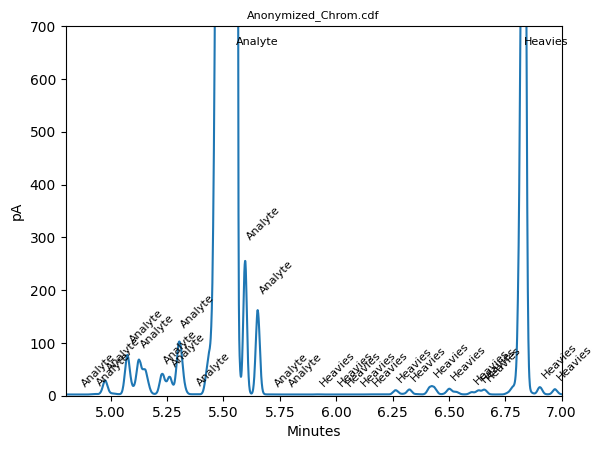

In [7]:
chrom.plot(scaled_ret_times=False, labels=True, xmin=4.8, xmax=7, ymax=700)

### Normalize retention times by the main analyte peak and plot the adjusted chromatogram

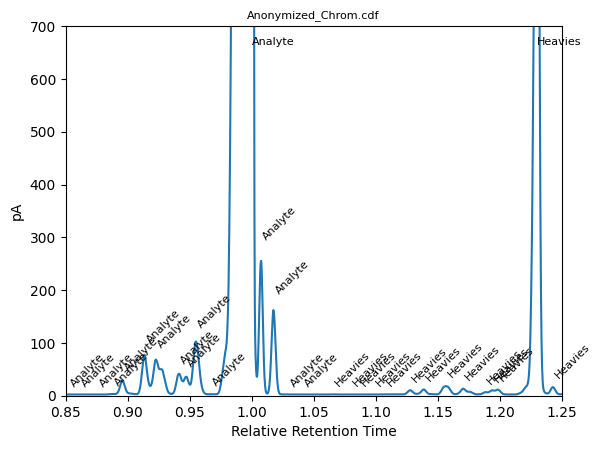

In [8]:
chrom.scale_ret_times_by_anchor('Analyte')
chrom.plot(scaled_ret_times=True, labels=True, xmin=0.85, xmax=1.25, ymax=700)

### Now that we have built some functionality, we can start collecting multiple chromatograms

In [9]:
def pull_chromatograms(instrument, default_path=True, path='', search_term=None):
    """
    Read in all .cdf files for an instrument and convert them to Chromatogram objects.

    Params:
        instrument (str):  Name of instrument from which chromatograms will be pulled.
    """

    if default_path:
        # anonymized location of chromatograms
        with open('chrom_path.txt', 'r') as file:
            path = file.read()
            path = os.path.join(path, instrument, 'CDF')
    else:
        path = path

    chromatograms = []
    for file in os.listdir(path):
        if search_term:
            if file.startswith(search_term) and file.endswith('.cdf'):
                filepath = os.path.join(path, file)
                dataset = Dataset(filepath, 'r')
                chromatogram = Chromatogram(dataset, file)
                chromatograms.append(chromatogram)
            else:
                pass
        else:
            filepath = os.path.join(path, file)
            dataset = Dataset(filepath, 'r')
            chromatogram = Chromatogram(dataset, file)
            chromatograms.append(chromatogram)

    return chromatograms

In [10]:
chroms = pull_chromatograms('Channel 101')

##### Since we need all the features to be uniform, we'll discard some older chromatograms that don't fit what we're trying to do

In [11]:
usable_chroms = []
for chrom in chroms:
    try:
        chrom.scale_ret_times_by_anchor('Butyraldehyde-IS')
        usable_chroms.append(chrom)
    except KeyError:
        pass

print(f"There are {len(usable_chroms)} usable chromatograms.")

There are 74 usable chromatograms.


## Explore a bare-bones anomaly detection algorithm

The first thing we need to do is to decide which features will be used for anomaly detection.  Right now, we will ignore processing raw chromatograms and instead look to the easier case of building feature vectors from peak groups.  Specifically, we want chromatograms of a given type to yield the following (for named groups A, B, and C):

1.  Major Peak A relative retention time.
2.  Area of Major Peak A (or area% for normalized methods).
3.  Group A relative retention time definition (ensuring a fixed number of elements if the group interval is broken).
4.  Number of peaks in group A.
5.  Major Peak B relative retention time.
6.  ...
7.  Number of peaks in group C.
___
For this example, we will use FAH, ACH, and Butyraldehyde as the group features.

In [12]:
def extract_group_summaries(chroms, reference_peak, analytes):
    """ Helper function for extracting group summary features from an array of chromatogram objects. """
    
    feature_tensor = []
    for chrom in chroms:
        # scale retention times to an anchor peak
        chrom.scale_ret_times_by_anchor(reference_peak)
        
        feature_matrix = []
        for group_name in analytes:
            # collect data that summarizes a peak group
            group = chrom.peak_groups[group_name]
            maj_peak = group.get_major_peak()
            ret_time = maj_peak.rrt_apex
            norm_area = maj_peak.area / chrom.total_area
            peak_count = len(group.peaks)

            feature_vec = [ret_time, norm_area, group.global_start, group.global_stop, peak_count]
            feature_matrix.append(feature_vec)

        feature_tensor.append(feature_matrix)

    feature_tensor = np.asarray(feature_tensor)

    return feature_tensor

In [13]:
analytes = ["Formaldehyde", "Acetaldehyde", "Butyraldehyde-IS"]
group_summaries = extract_group_summaries(usable_chroms, 'Butyraldehyde-IS', analytes)

In [14]:
# reshape the feature tensor into a 2D matrix by concatenating group features for each sample
num_analytes = len(analytes)
num_features = group_summaries.shape[-1]
feature_matrix = group_summaries.reshape(-1, num_analytes*num_features)

In [15]:
%%capture
from sklearn.ensemble import IsolationForest

# train an unsupervised anomaly detection model
model = IsolationForest(contamination=0.01)
model.fit(feature_matrix)

In [16]:
# get outlier scores (lower/more negative, the more likely an outlier)
outs = model.decision_function(feature_matrix)
# check which chromatogram indices are classified as outliers
outlier_idx = np.where(outs < 0)[0][0]
print(f"Outlier at index: {outlier_idx}.")

Outlier at index: 34.


## Let's look at some more domain-informed feature engineering

We know that the peak groups represent ordered series of peak objects.  Instead of summarizing them merely by peak count and group retention times, we would like to use algorithm that takes in whole sequences as features and perform anomaly detection those outputs.  We have options on how to approach the problem.  
___

We will start by converting each peak group to an array of (retention time, area count) values.  These can optionally be padded to some constant length to ensure each array is the same size.  We will also generate the portion of the chromatogram representing each peak group when processing the data.

Then, we can use a lightweight algorithm (i.e. *NOT* an LSTM or 1D convolutional network) to model the typicality of these peak sequences for each group.  

The trouble with that approach is twofold--the best algorithms for sequence data either need sequences that are *longer* than the short arrays of a few peaks that we see here (i.e. ROCKET), or they require more data that we can yet provide.  So, while we will hold onto the peak array data that we collect below, we will use a different strategy described later for reasoning about sequences.  

In [17]:
def extract_group_features(chrom, group_name, seq_length=-1, padding=True):
    """ Returns a list of peak features and a masking vector for a given group in a chromatogram, both of which padded to uniform size. """
    
    peak_feats = []
    mask_vec = []
    try:
        group = chrom.peak_groups[group_name]
    except KeyError as e:
        # error in group name definition
        raise KeyError(f"'{group_name}' is not a group in {chrom.name}. Be sure that the group name is spelled correctly.") from e

    # build feature and masking vectors
    peaks = group.peaks
    for peak in peaks:
        # add the RRT and normalized peak area as peak-level features
        peak_feats.append([peak.rrt_apex, peak.area / chrom.total_area])
        # record that a peak was found with valid features
        mask_vec.append([1, 1])

    if padding:
        # pad as necessary, or warn the user if they are trying to set seq_length to something smaller than the number of peaks in the group
        feat_size = len(peak_feats)
        if feat_size < seq_length:
            # use zero padding to build sequence and masking vectors to a uniform length
            delta = seq_length - feat_size
            for i in range(delta):
                peak_feats.append([0, 0])
                mask_vec.append([0, 0])

        elif feat_size > seq_length and seq_length > 0:
            warnings.warn(f"There are {feat_size} peaks in the {group_name} group, but seq_length is set to {seq_length}. Check the desired sequence length before continuing.")

        # convert the return values to ndarrays
        peak_feats = np.asarray(peak_feats)
        mask_vec = np.asarray(mask_vec)

    # peak_feats and mask_vec will be padded ndarrays if padding=True, or jagged Awkward arrays otherwise
    return peak_feats, mask_vec

In [18]:
def process_chromatogram(chrom, groups, seq_length=-1, sig_length=-1, padding=True):
    """ Extract the features from a single chromatogram. """

    if seq_length == -1 or sig_length == -1:  # figure out the max sequence and lengths in the chromatogram for padding purposes
        for group_name in groups:
            try: 
                group = chrom.peak_groups[group_name]
                group_size = len(group.peaks)
                signal_length = len(chrom.get_group_signal(group))

                seq_length = max(seq_length, group_size)
                sig_length = max(sig_length, signal_length)

            except KeyError:
                # error in group name definition
                print(f"'{group_name}' is not a group in {chrom.name}. Be sure that the group name is spelled correctly.")
                return
    
    # check for invalid inputs
    elif (seq_length < 0 and seq_length != -1) or not isinstance(seq_length, int):
        raise ValueError(f"seq_length cannot be set to {seq_length}. It must be set either to either a positive integer or to -1.")
    elif (sig_length < 0 and seq_length != -1) or not isinstance(seq_length, int):
        raise ValueError(f"sig_length cannot be set to {seq_length}. It must be set either to either a positive integer or to -1.")

    features = []  # chromatogram-level feature vector
    masks = []     # chromatogram-level mask vector
    group_signals = []
    for group in groups:
        # feature extraction step
        peak_feats, mask_vec = extract_group_features(chrom, group, seq_length, padding=padding)
        features.append(peak_feats)
        masks.append(mask_vec)
            
        group_signal = chrom.get_group_signal(chrom.peak_groups[group])
        group_signals.append(group_signal)

    if padding:
        # convert to ndarrays
        features = np.array(features)
        masks = np.array(masks)

        # pad the signals with zeroes
        for idx, signal in enumerate(group_signals):
            signal_length = len(signal)
            if signal_length < sig_length:
                delta = sig_length - signal_length
                group_signals[idx] = np.pad(signal, pad_width=(0, delta), constant_values=0)

        # finally, convert to ndarray
        group_signals = np.array(group_signals)
        
    else:
        features = ak.Array(features)
        masks = ak.Array(masks)
        group_signals = ak.Array(group_signals)

    return features, masks, group_signals

In [19]:
def process_all_chroms(chroms, groups, seq_length=-1, sig_length=-1, padding=True):
    """ Extract the features from an iterable collection of chromatograms. """

    if seq_length == -1:  # figure out the max sequence length in the dataset and pad every shorter feature vector to that length
        for chrom in chroms:
            for group_name in groups:
                try: 
                    group = chrom.peak_groups[group_name]
                    group_size = len(group.peaks)
                    signal_length = len(chrom.get_group_signal(group))

                    seq_length = max(seq_length, group_size)
                    sig_length = max(sig_length, signal_length)
                        
                except KeyError:
                    # error in group name definition
                    print(f"'{group_name}' is not a group in {chrom.name}. Be sure that the group name is spelled correctly.")
                    return

    # check for invalid inputs
    elif (seq_length < 0 and seq_length != -1) or not isinstance(seq_length, int):
        raise ValueError(f"seq_length cannot be set to {seq_length}. It must be set either to either a positive integer or to -1.")
    
    feature_tensor = []  # dataset-wide features
    mask_tensor = []     # dataset-wide masks
    signal_tensor = []
    for chrom in chroms:
        chrom_features, chrom_masks, group_signals = process_chromatogram(chrom, groups, seq_length, sig_length, padding)
        feature_tensor.append(chrom_features)
        mask_tensor.append(chrom_masks)
        signal_tensor.append(group_signals)

    if padding:
        # convert to ndarrays
        try:
            feature_tensor = np.asarray(feature_tensor)
            mask_tensor = np.asarray(mask_tensor)
            signal_tensor = np.asarray(signal_tensor)
            
        except ValueError as e:
            raise ValueError(f"seq_length has been set to {seq_length}, and some groups in the dataset may be longer than that. Either set seq_length=-1 or use a larger value.") from e

    else:
        # convert to Awkward arrays, providing numpy-like syntax and functions to jagged arrays
        feature_tensor = ak.Array(feature_tensor)
        mask_tensor = ak.Array(mask_tensor)
        signal_tensor = ak.Array(signal_tensor)

    # feature_tensor and mask_tensor will be padded ndarrays if padding=True, or jagged Awkward arrays otherwise
    return feature_tensor, mask_tensor, signal_tensor 

___
The helper functions give us tensors with padded sequence values by default, because most of the time that is helpful.  However, certain distance measures will be negatively impacted by zero padding and will work better with jagged arrays.  So, when we choose not to apply padding, our data will take the form of jagged Awkward arrays. This won't be a problem as long as we know that the shape of the padded, rectangular tensors are:

(num_chromatograms, num_analytes, sequence_length, num_features)

Likewise, the jagged arrays will have analogous dimensions, albeit variable ones.  

No matter which method we use, we will need to write some custom scalers. Those will be implemented below.
___

In [20]:
class AwkwardScaler:
    """ Custom MinMax scaler class that works with our jagged Awkward arrays. """

    def __init__(self, tensor=False):
        """ Set min and max values for use in scaling calculations, as well as a flag to show whether the scaler has been fitted before using. """
        
        self.mins = 0
        self.maxes = 1
        self.fitted = False

        if tensor:
            self.fit(tensor)

    def fit(self, tensor):
        """ 
        Fit the scaler parameters to the supplied data.

        This works by flattening axis 2 on the group data tensor, which removes the "sequence length" channel from the data.  What that allows us
        to do is to get a list of chromatogram outputs that each have a vector of peak features without regard to grouping by analyte. This results 
        in a 3D tensor if the data is rectangular. In so doing, we can go through two rounds of vectorized min/max calculations.

        The first round essentially collects min/max features for each peak, such that you get a 2d jagged array that is as long as the biggest peak 
        group in your dataset.  

        The second round performs those calculations on the peak-level data to return an array that represents the overall min/max for each feature 
        across the whole dataset.  

        Subsequently, those min/max attributes are used to scale the data.

        Params:
            tensor (ak.Array):  A jagged Awkward array of dimensions analgous to (num_chromatograms, num_analytes, sequence_length, num_features).

        Returns:
            None
        """

        # flatten out the analyte channel/dimension
        flattened_tensor = ak.flatten(tensor, axis=2)

        # collect overall minimum values for each feature
        mins_by_peak = ak.min(flattened_tensor, axis=0)
        mins_by_feature = ak.min(mins_by_peak, axis=0)
        self.mins = mins_by_feature

        # collect overall maximum values for each feature
        maxes_by_peak = ak.max(flattened_tensor, axis=0)
        maxes_by_feature = ak.max(maxes_by_peak, axis=0)
        self.maxes = maxes_by_feature

        # set the fitted flag to allow us to transform future data later
        self.fitted = True

    def transform(self, tensor):
        """ Transform the supplied data if the scaler is already fitted. """
        
        if not self.fitted:
            warnings.warn("You are attempting to use an unfitted Awkward_Scaler object. Fit the scaler to data before using the transform() method.")
            return
            
        tensor_list = tensor.to_list()  # this is unfortunately necessary since awkward arrays are immutable

        # this inefficient, deeply-nested loop is another unfortunate result of using jagged arrays. 
        # most of our vectorization tools fail when you can't guarantee rectangular dimensions.
        # that doesn't stop my eyes from bleeding when I look at it, though.
        for idx0, chrom in enumerate(tensor_list):
            for idx1, group in enumerate(chrom):
                for idx2, peak in enumerate(group):
                    for idx3, feature in enumerate(peak):
                        min_val = self.mins[idx3]
                        max_val = self.maxes[idx3]
                        scaled_feature = (feature - min_val) / max_val
                        tensor_list[idx0][idx1][idx2][idx3] = scaled_feature

        transformed_tensor = ak.Array(tensor_list)

        return transformed_tensor

    def fit_transform(self, tensor):
        """ Fit and transform the supplied data in a single method. """
        
        self.fit(tensor)
        scaled_tensor = self.transform(tensor)

        return scaled_tensor

In [21]:
class MaskAwareScaler:
    """ Mask-aware scaler for use with padded data. """

    def __init__(self, tensor=False):

        self.mins = 0
        self.maxes = 1
        self.stds = 1
        self.means = 0

        self.fitted = False

        if tensor:
            self.fit(tensor)

    def fit(self, tensor, mask):
        """ Fit scaler to training data. """

        # start by filtering out real values by the mask tensor and reshape them into long feature columns
        size, num_analytes, num_peaks, num_features = tensor.shape
        real_values = tensor[mask == 1].reshape(-1, num_features)

        # set the statistics based only on mask-filtered values
        self.mins = real_values.min(axis=0)
        self.maxes = real_values.max(axis=0)
        self.stds = real_values.std(axis=0)
        self.means = real_values.mean(axis=0)

        # toggle the fitted flag
        self.fitted = True

    def transform(self, tensor, mask, method='minmax'):
        """ Transform the supplied data according to the mask and user-specified method. """

        if not self.fitted:
            warnings.warn("You are attempting to use an unfitted Mask_Aware_Scaler object. Fit the scaler to data before using the transform() method.")
            return

        size, num_analytes, num_peaks, num_features = tensor.shape

        # reshape the tensor and mask to make arithmetic possible with the scaler's min/max vectors
        reshaped_tensor = tensor.reshape(-1, 2)
        reshaped_mask = mask.reshape(-1, 2)

        if method == "minmax":
            # filter by the mask and apply minmax scaling on each real value, keeping zero padding everywhere else
            reshaped_scaled_vals = np.where(reshaped_mask, (reshaped_tensor - self.mins) / self.maxes, 0)
            
            # restore the original tensor shape
            scaled_tensor = reshaped_scaled_vals.reshape(size, num_analytes, num_peaks, num_features)
            return scaled_tensor

        elif method == "std":
            # filter by the mask and apply standard scaling on each real value, keeping zero padding everywhere else
            reshaped_scaled_vals = np.where(reshaped_mask, (reshaped_tensor - self.means) / self.stds, 0)
            
            # restore the original tensor shape
            scaled_tensor = reshaped_scaled_vals.reshape(size, num_analytes, num_peaks, num_features)
            return scaled_tensor

        else:
            raise Exception('The method parameter must be set to "minmax" or "std".')

    def fit_transform(self, tensor, mask, method='minmax'):
        """ Fit the scaler and transform the supplied data in a single step. """

        self.fit(tensor, mask)
        scaled_tensor = self.transform(tensor, mask, method)

        return scaled_tensor

##### Extract peak features + mask and all the group signals for the example chromatograms

In [22]:
analytes = ['Formaldehyde', 'Acetaldehyde', 'Butyraldehyde-IS']
peak_tensor, mask_tensor, signal_tensor = process_all_chroms(usable_chroms, analytes, padding=True)

##### Scale the peak-level features

In [23]:
scaler = MaskAwareScaler()
scaled_tensor = scaler.fit_transform(peak_tensor, mask_tensor)

##### Apply Dyanmic Time Warping transformations to the group signals and extract those features

In [24]:
def dtw_transform(ts1, ts2, sakoe_chiba_radius=10):
    """ Compute Dynamic Time Warping tranform on two time series and return features based on the dtw path. """

    # remove any padding that may be present
    ts1_trim = np.trim_zeros(ts1)
    ts2_trim = np.trim_zeros(ts2)

    # compute dynamic time warping
    path, distance = dtw_path(ts1_trim, ts2_trim, global_constraint="sakoe_chiba", sakoe_chiba_radius=sakoe_chiba_radius)

    # engineer dtw features
    offsets = [i - j for i,j in path]
    max_shifts = max(abs(offset) for offset in offsets)
    mean_shift = sum(abs(offset) for offset in offsets) / len(offsets)
    warp_length = len(path)

    return distance, max_shifts, mean_shift, warp_length

In [25]:
def get_pairwise_dtw_distances(signal_tensor, data_interval=0.02):
    """ 
    Extracts pairwise DTW distances over a tensor of group signals of shape (num_chroms, num_analytes, signal_length). The returned value will
    be a tensor of shape (num_analytes, num_chroms, num_chroms).
    """

    # set dimensions of the signal feature tensor and initialize with zeroes
    n_chroms = signal_tensor.shape[0]
    n_analytes = signal_tensor.shape[1]
    dist_tensor = np.zeros((n_analytes, n_chroms, n_chroms))

    radius = 0.2 / data_interval  # expected peak width of 0.2s --> expected number of datapoints in peak

    # it is necessary to use a slow loop instead of the vectorized cdist_dtw() function because we have to dynamically trim zeroes for each signal.
    # in practice the performance difference is immaterial.
    for analyte in range(n_analytes):
        for i in range(n_chroms):
            for j in range(i+1, n_chroms):
                sig1 = signal_tensor[i, analyte]
                sig2 = signal_tensor[j, analyte]
                sig1 = np.trim_zeros(sig1)
                sig2 = np.trim_zeros(sig2)

                dist_tensor[analyte,i,j] = dtw(sig1, sig2, global_constraint="sakoe_chiba", sakoe_chiba_radius=radius)

    return dist_tensor

In [26]:
# collect pairwise dtw distances for the training set
dtw_feats = get_pairwise_dtw_distances(signal_tensor)

## Our modeling strategy is two-pronged:

**First**, we will compute pairwise DTW distances across the training dataset, and then we will cluster them using K-Medoid Clustering. The advantage of using K-Medoids versus K-Means is that the former yields medoids that are real datapoints. That gives us access to all the usual chromatogram features of those medoids.

After clustering, we will make inferences by extracting the group signals from new chromatograms and finding their nearest medoid.  Then, we will compute the following features by making a DTW transform between the sample signal and the medoid signal for that group:

1. DTW distance
2. Max shift length
3. Mean shift length
4. Warp path length

In so doing, we get a vector of features that succinctly describe how similar a group signal is to that of a typical one. Our strategy of clustering the training data allows us to be more resilient to uninformative differences among instruments, columns, etc., provided the data we train with represents what we consider "normal".

**Second**, we will collect statistics on relative retention times, group definitions, and peak areas for each group and decide on thresholds at the 1st and 99th percentiles of each of those features. New samples will be flagged if any of their features exceed those thresholds. This is simple and requires no machine learning, but we will see that it is robust and interpretable. We will collectively call these features "group statistics":

1. Relative retention time of the major peak in the group
2. Normalized area counts for the whole group
3. Integration start time (relative)
4. Integration end time (relative)
5. Peak count for the group

Lastly, a major feature of our models is that they will be serializable and loadable from JSON configuration files--one per model.
___

### Now that we have extracted signal features for each group, we can establish K-Medoids clusters 

We will compute the distance of each new group signal to its nearest medoid and then engineer rich anomaly features from there.

In [27]:
def build_clusters(dtw_dists, analytes, signal_tensor, n_clusters=5):
    """ Helper function for building cluster models from pairwise DTW outputs. """

    # build a dictionary of cluster models for each analyte
    analyte_clusters = {}
    num_analytes = len(dtw_dists)
    for i in range(num_analytes):
        dists = dtw_dists[i]
        analyte = analytes[i]
        
        # build and fit the kmedoids model itself
        kmedoids = KMedoids(n_clusters=n_clusters, random_state=42)
        kmedoids.fit(dists)
        analyte_clusters[analyte] = kmedoids

        # filename for the serialized medoids of this cluster
        medoid_label = "medoids_" + analyte + ".npy"

        # get the medoid traces themselves and serialize them
        indices = kmedoids.medoid_indices_
        medoids = []
        for medoid_idx in indices:
            medoid_trace = signal_tensor[medoid_idx, i, :]  # this slice represents the original training data before dtw transform
            medoids.append(medoid_trace)

        medoids = np.asarray(medoids)  # already padded

        # serialize the medoid traces for this cluster
        file_path = os.path.join('Model Data', medoid_label.lower())
        np.save(file_path, medoids)

    # TODO: evaluate whether to return/keep the cluster objects at all, now that we've implemented serialization of their medoids
    return analyte_clusters

In [28]:
ach_clusters = build_clusters(dtw_feats, analytes, signal_tensor)

### We will now acquire statistics on how each sample in the training set relates to its nearest medoid

In [29]:
def apply_cluster(signal, analyte, dtw_window=10):
    """ 
    Helper function for calculating the nearest medoid in a set of clusters and calculating features from it. 

    Params:
        signal (array-like):    Chromatographic signal for a peak group.
        #cluster (KMedoids):     K-Medoids cluster object.
        analyte (str):          Name of analyte that this cluster applies to.  
        dtw_window (numeric):   Sakoe-chiba radius for the DTW algorithm. Usually equals the expected peak width in units of array elements.

    Returns:
        features (list):        DTW features returned by the dtw_transform() function.
    """

    # load the medoid traces for this cluster
    filename = "medoids_" + analyte + ".npy"
    file_path = os.path.join("Model Data", filename.lower())
    medoids = np.load(file_path)
    
    # compute the nearest medoid
    min_dist = np.inf
    closest_medoid = None
    for medoid_trace in medoids:
        unpadded_signal = np.trim_zeros(signal)
        unpadded_trace = np.trim_zeros(medoid_trace)
        distance = dtw(unpadded_signal, unpadded_trace, global_constraint="sakoe_chiba", sakoe_chiba_radius=dtw_window)
        if distance < min_dist:
            closest_medoid = unpadded_trace

    features = dtw_transform(unpadded_signal, closest_medoid, sakoe_chiba_radius=dtw_window)

    return features

In [30]:
def get_signal_feature_stats(signal_tensor, analytes, dtw_window=10):
    """ Helper function for computing statistics for engineered group signal features. """
    
    feature_tensor = []
    for sample in signal_tensor:
        analyte_features = []
        for group_signal, analyte in zip(sample, analytes):
            #cluster = cluster_dict[analyte]
            cluster_feats = apply_cluster(group_signal, analyte, dtw_window)
            analyte_features.append(cluster_feats)
        feature_tensor.append(analyte_features)

    feature_tensor = np.asarray(feature_tensor)

    return feature_tensor

In [31]:
feats = get_signal_feature_stats(signal_tensor, analytes)

##### We need an example configuration file schema that will give us flexibility in how we define models 

In [32]:
default_config = {
    "model_name": "Anomaly_Detector",
    "version": "0.1",
    "created_at": "2025-09-12",
    "trained_on": [],
    "parameters": {
        "dtw": {
            "sakoe_chiba_radius": 10,
        },
        "kmedoids": {
            "n_clusters": 5
        },
        "random_state": 42,
    },
    "medoids": {
   },
    "features": [],
    "thresholds": {
    },
    "is_fitted": False,
    "metadata": {
        "author": "Jordan Welch",
        "instrument_family": "GC",
        "agilent_method": "ACH",
        "notes": "Anchor RT normalized; area normalized to sum=1 per sample."
    }
}

##### We need to build an object to encapsulate the K-Medoids classifier data and behavior, and serialize its parameters so that it can be applied to new data later

In [33]:
class MedoidAnomalyDetector:
    """ Encapsulate the data and behaviors for a K-Medoids based anomaly detection model. """

    def __init__(self, name, version=None, radius=10, config_path=False):

        self.config = {'medoid_anomaly_detector': {}}
        self.config['medoid_anomaly_detector'].update({'parameters': {
            "dtw": {
                "sakoe_chiba_radius": 10,
            },
            "kmedoids": {
                "n_clusters": 5
            },
            "random_state": 42}
        } )

        self.is_fitted = False
        self.name = name
        self.version = version
        self.trained_analytes = None
        self.radius = radius
        self.features = ['dtw_distance', 'max_shift', 'mean_shift', 'warp_length']
        self.medoids = {}
        self.thresholds = {}
        
        if config_path:
            try:
                self._load_config(config_path)
            except Exception as e:
                raise Exception(f"Could not load {config_path}. Check whether the file path exists or whether the model has been trained.") from e

    def _load_config(self, config_path):
        """ Load data and parameters from config file. """
        try:
            with open(config_path, 'r') as file:
                config = json.load(file)
                # check for a null config file, which can happen under certain kinds of bugs
                if not config:
                    return
            
            # checking for the case in which the config file exists but does not include this model
            if "medoid_anomaly_detector" not in config:
                config.update(self.config)
                self.config = config
                
            # copy over the model parameters if the model is represented in the config file
            else:
                self.config = config
                params = config['medoid_anomaly_detector']['parameters']
                self.n_clusters = params['kmedoids']['n_clusters']
                self.radius = params['dtw']['sakoe_chiba_radius']
                self.name = config['medoid_anomaly_detector']['model_name']
                self.version = config['medoid_anomaly_detector']['version']
                self.trained_analytes = config['medoid_anomaly_detector']['trained_on']
                self.features = config['medoid_anomaly_detector']['features']
        
                # load the medoid traces from the filepaths specified in the config file
                self.medoids = {
                    analyte: np.load(os.path.join('Model Data', filename))
                    for analyte, filename in self.config['medoid_anomaly_detector']['medoids'].items()
                }

                self.is_fitted = config['medoid_anomaly_detector']['is_fitted']
                self.thresholds = config['medoid_anomaly_detector']['thresholds']
                self.metadata = config['medoid_anomaly_detector']['metadata']

        except FileNotFoundError:
            # we will write this file after fitting
            return

    def fit(self, signal_tensor, analytes, config_dir='', percentile=99):
        """ 
        Overall fitting of the medoid anomaly detector model.  First computes a pairwise DTW distance across each group signal for each analyte
        in the dataset. Then fits K-Medoids clusters for each analyte and records the medoid values.  Then computes a feature vector for each sample 
        according to its nearest medoid.  Then percentiles are computes for each feature in the dataset to determine thresholds.
        """

        # compute pairwise dtw distances in the training data and build clusters around it 
        self.trained_analytes = analytes
        dtw_dists = self.get_pairwise_dtw_distances(signal_tensor)
        self._build_clusters(dtw_dists, analytes, signal_tensor)
        # compute dtw feature tensor for the training data
        feats = self.get_signal_feature_stats(signal_tensor)

        # compute the thresholds as a percentile of each dtw feature
        for i, analyte in enumerate(self.trained_analytes):
            if analyte not in self.thresholds:
                self.thresholds[analyte] = {}
            for j, feature in enumerate(self.features):
                # get the specified percentile level for each feature (default 99th percentile)
                data_slice = feats[:, i, j]
                threshold = np.percentile(data_slice, percentile)
                self.thresholds[analyte].update({feature: threshold})

        self.is_fitted = True
        
        # update the configs with fitted parameters
        config_path = self._update_config(config_dir)

    def _update_config(self, config_dir):
        """ Populate the config file for this model. Meant to be called after training."""

        # as a reminder, we're setting a reference to this attribute to the config variable
        config = self.config['medoid_anomaly_detector']
        
        config['trained_on'] = self.trained_analytes
        config['features'] = self.features
        config['is_fitted'] = self.is_fitted
        config['model_name'] = self.name
        config['version'] = self.version
        config['metadata'] = {
            "author": "Jordan Welch",
            "instrument_family": "GC",
            "notes": "Anchor RT normalized; area normalized to sum=1 per sample."
        }
        
        config['medoids'] = {}
        config['thresholds'] = self.thresholds
        
        for i, analyte in enumerate(self.trained_analytes):
            # the medoids filenames will always take this format
            filename = ("medoids_" + analyte + ".npy").lower()
            config['medoids'].update({analyte: filename})
        
        # serialize the config parameters to a file
        config_name = (self.name + "_config.json").lower()
        config_path = os.path.join(config_dir, config_name)

         # open the latest copy of the config file, if it exists, in case it's been modified since this model was instantiated
        latest_config = None
        try:
            with open(config_path, 'r') as file:
                latest_config = json.load(file)
                latest_config.update(self.config)
                self.config = latest_config
        except (FileNotFoundError, AttributeError):  # the file may not exist, or it may exist and contain null contents
            pass

        if latest_config:
            self.config = latest_config
            
        # serialize the config file
        with open(config_path, 'w') as file:
            json.dump(self.config, file, indent=4)

        return config_path

    def score(self, signal, analyte, train=False):
        """ Compute the feature vector and score it against the model thresholds """
        
        # compute the nearest medoid
        medoid, cluster_id = self.get_nearest_medoid(signal, analyte)

        # compute the feature vector and then decide whether it meets the configured thresholds
        features = dtw_transform(signal, medoid, sakoe_chiba_radius=self.radius)

        if train:  # a vector of exceedances is not meaningful in the middle of training
            return features
            
        exceedances = []
        for feat, threshold in zip(features, self.thresholds[analyte]):
            threshold_value = self.thresholds[analyte][threshold]
            exceedances.append(feat > threshold_value)

        return features, exceedances

    def dtw_transform(self, ts1, ts2, sakoe_chiba_radius=10):
        """ Compute Dynamic Time Warping tranform on two time series and return features based on the dtw path. """

        # remove any padding that may be present
        ts1_trim = np.trim_zeros(ts1)
        ts2_trim = np.trim_zeros(ts2)

        # compute dynamic time warping
        path, distance = dtw_path(ts1_trim, ts2_trim, global_constraint="sakoe_chiba", sakoe_chiba_radius=sakoe_chiba_radius)

        # engineer dtw features
        offsets = [i - j for i,j in path]
        max_shifts = max(abs(offset) for offset in offsets)
        mean_shift = sum(abs(offset) for offset in offsets) / len(offsets)
        warp_length = len(path)

        return distance, max_shifts, mean_shift, warp_length

    def get_pairwise_dtw_distances(self, signal_tensor, data_interval=0.02):
        """ 
        Extracts pairwise DTW distances over a tensor of group signals of shape (num_chroms, num_analytes, signal_length). The returned value will
        be a tensor of shape (num_analytes, num_chroms, num_chroms).
        """

        # set dimensions of the signal feature tensor and initialize with zeroes
        n_chroms = signal_tensor.shape[0]
        n_analytes = signal_tensor.shape[1]
        dist_tensor = np.zeros((n_analytes, n_chroms, n_chroms))

        radius = 0.2 / data_interval  # expected peak width of 0.2s --> expected number of datapoints in peak

        # it is necessary to use a slow loop instead of the vectorized cdist_dtw() function because we have to dynamically trim zeroes for each signal.
        # in practice the performance difference is immaterial.
        for analyte in range(n_analytes):
            for i in range(n_chroms):
                for j in range(i+1, n_chroms):
                    sig1 = signal_tensor[i, analyte]
                    sig2 = signal_tensor[j, analyte]
                    sig1 = np.trim_zeros(sig1)
                    sig2 = np.trim_zeros(sig2)

                    dist_tensor[analyte,i,j] = dtw(sig1, sig2, global_constraint="sakoe_chiba", sakoe_chiba_radius=radius)

        return dist_tensor

    def _build_clusters(self, dtw_dists, analytes, signal_tensor, n_clusters=5):
        """ Helper method for building cluster models from pairwise DTW outputs. """

        # build a dictionary of cluster models for each analyte
        analyte_clusters = {}
        num_analytes = len(dtw_dists)
        for i in range(num_analytes):
            dists = dtw_dists[i]
            analyte = analytes[i]
        
            # build and fit the kmedoids model itself
            kmedoids = KMedoids(n_clusters=n_clusters, random_state=42)
            kmedoids.fit(dists)

            # get the medoid traces themselves and serialize them
            indices = kmedoids.medoid_indices_
            medoids = [signal_tensor[medoid_idx, i, :] for medoid_idx in indices]  # this slice represents the original training data before dtw transform
            medoids = np.asarray(medoids)  # already padded

            # set the medoid traces to the medoids attribute
            self.medoids.update({analyte: medoids})

            # filename for the serialized medoids of this cluster
            medoid_label = "medoids_" + analyte + ".npy"
            # serialize the medoid traces for this cluster
            file_path = os.path.join('Model Data', medoid_label.lower())
            np.save(file_path, medoids)

    def get_nearest_medoid(self, signal, analyte):
        """ Get the medoid nearest to the supplied signal vector. """

        min_dist = np.inf
        closest_medoid = None
        closest_idx = None
        for cluster_idx, medoid_trace in enumerate(self.medoids[analyte]):
            # unpad all the traces
            unpadded_signal = np.trim_zeros(signal)
            unpadded_trace = np.trim_zeros(medoid_trace)
            # compute dtw distance for a given medoid
            distance = dtw(unpadded_signal, unpadded_trace, global_constraint="sakoe_chiba", sakoe_chiba_radius=self.radius)
            if distance < min_dist:
                closest_medoid = unpadded_trace

        return closest_medoid, closest_idx

    def get_signal_feature_stats(self, signal_tensor):
        """ Method for computing statistics for engineered group signal features. """
    
        feature_tensor = []
        for sample in signal_tensor:
            analyte_features = []
            for group_signal, analyte in zip(sample, self.trained_analytes):
                cluster_feats = self.score(group_signal, analyte, train=True)
                analyte_features.append(cluster_feats)
            feature_tensor.append(analyte_features)

        feature_tensor = np.asarray(feature_tensor)

        return feature_tensor

### The per-group anomaly detector works. Now, we can explore using a lightweight feature extraction and classification algorithm for the entire chromatogram signal.

While the medoid anomaly detector will be sensitive to group-specific integration and peak issues, the overall chromatogram can also be used for anomaly detection. 

In [34]:
class GroupPercentileDetector:
    """ Class for calculating, storing, and using percentile limits for each feature in a dataset. """
    
    def __init__(self, name, config_path=False):
    
        self.name = name
        self.config = {'group_percentile_detector': {}}
        self.analytes = []
        self.thresholds = {}
        self.features = []

        if config_path:
            try:
                self._load_config(config_path)
            except Exception as e:
                raise Exception(f"Could not load {config_path}.") from e
            
    def fit(self, X, analytes, percentile=99, config_folder='', features=['rrt', 'normalized_area', 'group_start', 'group_stop', 'peak_count']):
        """ Determine and store percentile limits for each feature or property. """
        
        # check for the case in which there is only one peak group in the dataset
        if len(X.shape) < 3:
            num_samples = X.shape[0]
            num_features = X.shape[1]
            X = X.reshape((num_samples, 0, num_features))
            
        self.analytes = analytes
        self.features = features

        for sample in X:
            for i, analyte in enumerate(analytes):
                if analyte not in self.thresholds:
                    self.thresholds[analyte] = {}
                for j, feature in enumerate(features):
                    data_slice = X[:, i, j]
                    upper_limit = np.percentile(data_slice, percentile)
                    lower_limit = np.percentile(data_slice, (100-percentile))
                    self.thresholds[analyte].update({feature: {"upper_limit": upper_limit, "lower_limit": lower_limit}})

        self._update_config(config_folder)

    def score(self, feature_vector, analyte):
        """ Compare a feature vector to stored thresholds. """

        # list of values that exceeded limits
        exceedances = []
        interpretations = []
        for result, feature_type in zip(feature_vector, self.features):
            upper_limit = self.thresholds[analyte][feature_type]['upper_limit']
            lower_limit = self.thresholds[analyte][feature_type]['lower_limit']

            exceedances.append([result > upper_limit, result < lower_limit])
            if result > upper_limit:
                interp = f"{feature_type} for {analyte} exceeds max limit of {upper_limit} with a value of {result}."
                interpretations.append(interp)
            elif result < lower_limit:
                interp = f"{feature_type} for {analyte} exceeds minimum limit of {lower_limit} with a value of {result}."
                interpretations.append(interp)

        return exceedances, interpretations

    def _load_config(self, config_file):
        """ Build up the model parameters from a config file. """

        try:
            with open(config_file, 'r') as file:
                config = json.load(file)
                # check for a null config file, which can happen under certain kinds of bugs
                if not config:
                    return
        
            # check for the case in which the config file exists but doesn't contain parameters for this model
            if "group_percentile_detector" not in config:
                config.update(self.config)
                self.config = config
            # copy over model parameters if the model is represented in the config file
            else:
                self.config = config
                self.name = config['group_percentile_detector']['name']
                self.analytes = config['group_percentile_detector']['analytes']
                self.thresholds = config['group_percentile_detector']['thresholds']
                self.features = config['group_percentile_detector']['features']
                
        except FileNotFoundError:
            # we will write this file after fitting
            return
            

    def _update_config(self, config_folder):
        """ Update the config property after fitting the model to data and serialize it in JSON format. """
        
        config = self.config['group_percentile_detector']
        config['name'] = self.name
        config['analytes'] = self.analytes
        config['thresholds'] = self.thresholds
        config['features'] = self.features

        filename = (self.name + "_config.json").lower()
        config_path = os.path.join(config_folder, filename)

        # open the latest copy of the config file, if it exists, in case it's been modified since this model was instantiated
        try:
            with open(config_path, 'r') as file:
                latest_config = json.load(file)
                latest_config.update(self.config)
                self.config = latest_config
        except (FileNotFoundError, AttributeError):  # the file may not exist, or it may exist and contain null contents
            pass

        # serialize the config file
        with open(config_path, 'w') as file:
            json.dump(self.config, file, indent=4)

In [35]:
class AnomalyDetector:
    """ Encapsulates the entirety of our anomaly detection strategies and provides pipelines for data transformations. """

    def __init__(self, method_name, config_dir, config_filename, medoid_detector=None, group_scorer=None):

        self.name = method_name
        self.config_dir = config_dir
        self.config_path = os.path.join(config_dir, config_filename)
        self.analytes = None
        self.medoid_detector = medoid_detector
        self.group_scorer=group_scorer
        
        if not medoid_detector:
            self.medoid_detector = MedoidAnomalyDetector(self.name, config_path=self.config_path)
            self.group_scorer = GroupPercentileDetector(self.name, config_path=self.config_path)
            
    def fit(self, chroms, analytes):
        """ Fit the individual anomaly detection models to data. """

        self.analytes = analytes

        signal_tensor = self._get_dataset_signals(chroms, analytes)
        group_summaries = self._get_group_summaries(chroms, analytes)

        self.medoid_detector.fit(signal_tensor, analytes, self.config_dir)
        self.group_scorer.fit(group_summaries, analytes, config_folder=self.config_dir)

    def score(self, chrom, analyte):
        """ Score a chromatogram as an anomaly or not. """

        group = chrom.peak_groups[analyte]
        group_signal = chrom.get_group_signal(group)

        group_features = self._get_group_summaries([chrom], [analyte])[0][0]

        medoid_scores, medoid_exceedances = self.medoid_detector.score(group_signal, analyte)
        group_exceedances, interpretations = self.group_scorer.score(group_features, analyte)

        return medoid_scores, medoid_exceedances, group_exceedances, interpretations
        
    def _get_group_signals(self, chrom, groups, sig_length=-1):
        """ Extract the group-specific signals from a single chromatogram. """

        if sig_length == -1:  # figure out the max sequence and lengths in the chromatogram for padding purposes
            for group_name in groups:
                try: 
                    group = chrom.peak_groups[group_name]
                    signal_length = len(chrom.get_group_signal(group))
                    sig_length = max(sig_length, signal_length)
                    
                except KeyError:
                    # error in group name definition
                    print(f"'{group_name}' is not a group in {chrom.name}. Be sure that the group name is spelled correctly.")
                    return
    
        # check for invalid inputs
        elif (sig_length < 0 and sig_length != -1) or not isinstance(sig_length, int):
            raise ValueError(f"sig_length cannot be set to {seq_length}. It must be set either to either a positive integer or to -1.")

        group_signals = []  # vector of detector signals for each group
        for group in groups:
            # feature extraction step
            group_signal = chrom.get_group_signal(chrom.peak_groups[group])
            group_signals.append(group_signal)

        # pad the signals with zeroes
        for idx, signal in enumerate(group_signals):
            signal_length = len(signal)
            if signal_length < sig_length:
                delta = sig_length - signal_length
                group_signals[idx] = np.pad(signal, pad_width=(0, delta), constant_values=0)

        # finally, convert to ndarray
        group_signals = np.array(group_signals)

        return group_signals

    def _get_dataset_signals(self, chroms, groups, sig_length=-1):
        """ Extract the features from an iterable collection of chromatograms. """

        if sig_length == -1:  # figure out the max sequence length in the dataset and pad every shorter feature vector to that length
            for chrom in chroms:
                for group_name in groups:
                    try: 
                        group = chrom.peak_groups[group_name]
                        signal_length = len(chrom.get_group_signal(group))
                        sig_length = max(sig_length, signal_length)
                        
                    except KeyError:
                        # error in group name definition
                        print(f"'{group_name}' is not a group in {chrom.name}. Be sure that the group name is spelled correctly.")
                        return
    
        signal_tensor = []
        for chrom in chroms:
            group_signals = self._get_group_signals(chrom, groups, sig_length)
            signal_tensor.append(group_signals)

        # convert to ndarray
        signal_tensor = np.asarray(signal_tensor)

        # feature_tensor and mask_tensor will be padded ndarrays if padding=True, or jagged Awkward arrays otherwise
        return signal_tensor 

    def _get_group_summaries(self, chroms, analytes):
        """ Helper method for extracting group summary features from an array of chromatogram objects. """
    
        feature_tensor = []
        for chrom in chroms:
            
            feature_matrix = []
            for group_name in analytes:
                # collect data that summarizes a peak group
                group = chrom.peak_groups[group_name]
                maj_peak = group.get_major_peak()
                ret_time = maj_peak.rrt_apex
                norm_area = maj_peak.area / chrom.total_area
                peak_count = len(group.peaks)

                feature_vec = [ret_time, norm_area, group.global_start, group.global_stop, peak_count]
                feature_matrix.append(feature_vec)

            feature_tensor.append(feature_matrix)

        feature_tensor = np.asarray(feature_tensor)

        return feature_tensor

In [36]:
def plot_traces(chroms, analyte):
    """ Utility function for plotting chromatogram traces for a specified analyte/group in a dataset. """
    
    fig = plt.Figure()
    ax = plt.subplot()
    for chrom in chroms:
        group = chrom.peak_groups[analyte]
        sig = chrom.get_group_signal(group)
        ax.plot(np.trim_zeros(sig))
        ax.set_title(analyte)
        ax.set_ylabel('Normalized Area Counts')

### Train a few models on limited data and see how well they work

##### Aldehyde Model

In [37]:
ach_anom = AnomalyDetector('ACH', 'Model Data', 'ach_config.json')

In [38]:
analytes = ['Formaldehyde', 'Acetaldehyde', 'Butyraldehyde-IS']
ach_anom.fit(usable_chroms, analytes)

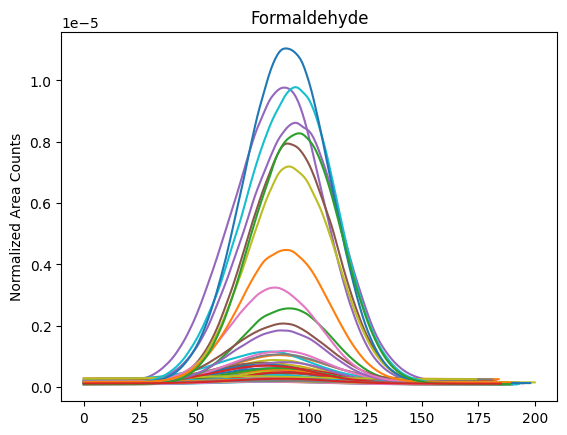

In [40]:
plot_traces(usable_chroms, 'Formaldehyde')

##### C23 Model
___
In this case we've prepared an anomalous chromatogram on purpose, so we can see how well the anomaly detector catches it. Let's see how it goes.
___

In [41]:
alc23_113 = pull_chromatograms('Channel 113_114', search_term='23 ALC')
alc23_78 = pull_chromatograms('Channel 007_008', search_term='23 ALC')

alc23 = alc23_113 + alc23_78

for chrom in alc23:
    chrom.scale_ret_times_by_anchor('C13 Alcohol Normal')

In [42]:
# fit the C23 model
alc23_analytes = ['C12 Alcohol ', 'C12 Alcohol Normal', 'C13 Alcohol', 'C13 Alcohol Normal', 'C14 Alcohol', 'C14 Alcohol Normal']
alc23_anom = AnomalyDetector('23 ALC', 'Model Data', '23 alc.config')
alc23_anom.fit(alc23, alc23_analytes)

## It works!

In [43]:
# pull the anomalous chromatogram
anomaly_folder = os.path.join('Anomalies')
for anomaly in os.listdir(anomaly_folder):
    filepath = os.path.join(anomaly_folder, anomaly)
    cdf = Dataset(filepath, 'r')
    anomaly = Chromatogram(cdf, anomaly)

for analyte in alc23_analytes:
    print(alc23_anom.score(anomaly, analyte)[3])

['rrt for C12 Alcohol  exceeds max limit of 0.7468596792189376 with a value of 3.7086665837715063.']
['rrt for C12 Alcohol Normal exceeds max limit of 0.8251123033872687 with a value of 5.459333211307724.']
['rrt for C13 Alcohol exceeds max limit of 0.9230762667623384 with a value of 4.915333223467072.']
['rrt for C13 Alcohol Normal exceeds max limit of 1.0 with a value of 6.714666516582171.', 'normalized_area for C13 Alcohol Normal exceeds minimum limit of 0.07919823359698058 with a value of 0.003363882889971137.']
['rrt for C14 Alcohol exceeds max limit of 1.130761708416511 with a value of 5.889666535022358.', 'group_stop for C14 Alcohol exceeds minimum limit of 6.449533367156983 with a value of 6.445333480834961.']
['rrt for C14 Alcohol Normal exceeds max limit of 1.2281879142626801 with a value of 7.994333154646058.', 'normalized_area for C14 Alcohol Normal exceeds minimum limit of 0.0007906124461442232 with a value of 0.0003848396008834243.']
